<a href="https://colab.research.google.com/github/amolkerkar/BERT/blob/main/SMS_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
device = torch.device("cuda")

In [2]:
from google.colab import files
print("upload the SMS_spam_data.csv file from the data folder")
files.upload()

Saving spamdata_v2.csv to spamdata_v2.csv


{'spamdata_v2.csv': b'label,text\n0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."\n0,Ok lar... Joking wif u oni...\n1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'s\n0,U dun say so early hor... U c already then say...\n0,"Nah I don\'t think he goes to usf, he lives around here though"\n1,"FreeMsg Hey there darling it\'s been 3 week\'s now and no word back! I\'d like some fun you up for it still? Tb ok! XxX std chgs to send, \xc3\xa5\xc2\xa31.50 to rcv"\n0,Even my brother is not like to speak with me. They treat me like aids patent.\n0,As per your request \'Melle Melle (Oru Minnaminunginte Nurungu Vettam)\' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune\n1,WINNER!! As a valued network customer you have been selected to receivea \xc3\xa5\xc2\xa3900 prize reward! To clai

In [3]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [6]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<Axes: >

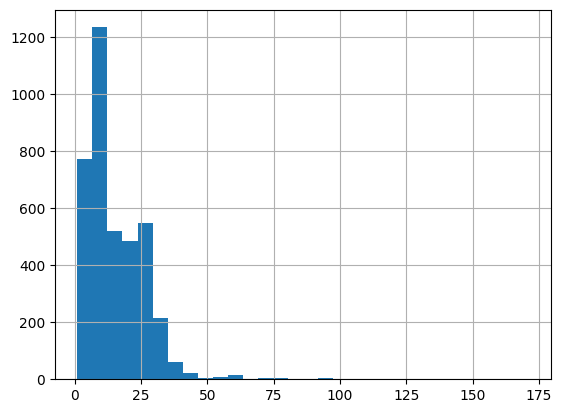

In [7]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [8]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
for param in bert.parameters():
    param.requires_grad = False

In [12]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [13]:
model = BERT_Arch(bert)
model = model.to(device)


In [14]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
type(set(train_labels))
set(train_labels)
len(list(train_labels))

3900

In [16]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [24]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights)
epochs = 40

In [25]:
def train():

    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
    for step,batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)

    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [26]:
def evaluate():

    print("\nEvaluating...")

    model.eval()

    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step,batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        with torch.no_grad():

            preds = model(sent_id, mask)

            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)

    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [27]:

best_valid_loss = float('inf')


train_losses=[]
valid_losses=[]


for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))


    train_loss, _ = train()


    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.362
Validation Loss: 0.330

 Epoch 2 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.355
Validation Loss: 0.326

 Epoch 3 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.349
Validation Loss: 0.315

 Epoch 4 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.337
Validation Loss: 0.308

 Epoch 5 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.327
Validation Loss: 0.310

 Epoch 6 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.325
Validation Loss: 0.308

 Epoch 7 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.313
Validation Loss: 0.297

 Epoch 8 / 40
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.307
Validat

In [28]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [29]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [30]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       724
           1       0.73      0.95      0.82       112

    accuracy                           0.94       836
   macro avg       0.86      0.95      0.89       836
weighted avg       0.96      0.94      0.95       836

